In [10]:
import numpy as np
import pandas as pd
import os

import imageio
import rasterio
import geopandas as gpd
from shapely.geometry import Point, Polygon, box

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

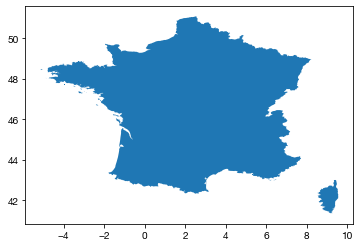

In [4]:
france = geopandas.read_file('../mount/data/gadm36_FRA_shp/gadm36_FRA_0.shp')

fig, ax = plt.subplots(1)
france.plot(ax=ax)
plt.show()

In [4]:
france

,GID_0,NAME_0,geometry
0,FRA,France,"MULTIPOLYGON (((9.25764 41.34903, 9.25764 41.3..."


In [5]:
france_geom = france.iloc[0]['geometry']

In [6]:
france_geom.bounds

(-5.14375114, 41.33375168, 9.56041622, 51.08939743)

In [7]:
n_samples = 10000
points = []
minx, miny, maxx, maxy = france_geom.bounds
print_every = 500

while len(points) < n_samples:

    lat = np.random.rand() * (maxy - miny) + miny
    lon = np.random.rand() * (maxx - minx) + minx

    point = Point([lon, lat])

    if point.within(france_geom):
        points.append([lon, lat])
        
    if len(points) % print_every == 0:
        print(len(points))

500
1000
1500
2000
2000
2000
2500
2500
3000
3500
3500
3500
4000
4000
4000
4000
4000
4500
5000
5500
5500
5500
6000
6500
6500
6500
7500
7500
8000
8000
8000
8500
8500
9000
9000
9500
9500
10000


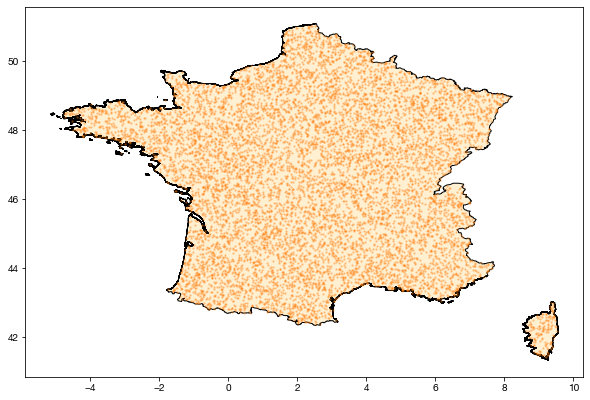

In [25]:
points = np.array(points)

fig, ax = plt.subplots(1, figsize=(10,15))
france.plot(ax=ax, edgecolor='black', color='#fff0d1')
plt.scatter(points[:,0], points[:,1], alpha=0.3, color='C1', s=2)
plt.show()

In [9]:
samples = pd.DataFrame(points, columns=['min_lon', 'min_lat'])
samples['image_id'] = [str(x).zfill(5) for x in np.arange(len(points))]

In [14]:
samples['max_lon'] = samples['min_lon'] + 1./(111111. * np.cos(samples['min_lat'] * np.pi / 180.)) * 300 * 3
samples['max_lat'] = samples['min_lat'] + 1./111111. * 300 * 3

In [18]:
samples.head()

,min_lon,min_lat,image_id,max_lon,max_lat
0,3.531187,45.170360,00000,3.542676,45.178460
1,0.591338,49.557181,00001,0.603825,49.565281
2,4.184958,46.215638,00002,4.196664,46.223738
3,1.540555,45.694366,00003,1.552152,45.702466
4,2.670917,44.683271,00004,2.682310,44.691371


In [15]:
samples.iloc[0]

min_lon     3.53119
min_lat     45.1704
image_id      00000
max_lon     3.54268
max_lat     45.1785
Name: 0, dtype: object

In [21]:
samples[['image_id', 'min_lon', 'min_lat', 'max_lon', 'max_lat']].to_csv(
#     '../mount/data/raw_data/France_samples_latlon_8000.csv',
    '../data/planet/france/sherrie10k/bbox10k.csv', index=False)

### Larger boxes (1250x1250)

In [11]:
samples = pd.read_csv('../data/planet/france/sherrie10k/bbox10k.csv', dtype=str)
img_size = 1250
samples['max_lon'] = samples['min_lon'].astype(float) + 1./(111111. * np.cos(samples['min_lat'].astype(float) * np.pi / 180.)) * img_size * 3
samples['max_lat'] = samples['min_lat'].astype(float) + 1./111111. * img_size * 3

In [13]:
samples.to_csv('../data/planet/france/sherrie10k/bbox10k_1250px.csv', index=False)

(1154, 1154, 4)


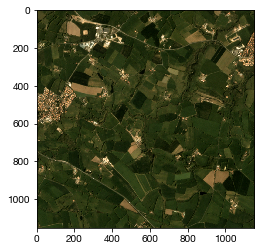

In [21]:
# after renaming
renamed = imageio.imread('../data/planet/france/sherrie10k/monthly_mosaics_renamed_clipped_merged/03912_2019_04.tif')
print(renamed.shape)
plt.imshow(renamed[:,:,:3])
# plt.imshow(np.moveaxis(renamed[:3,:,:], 0, -1))
plt.show()

### Even larger boxes (2500x2500)

In [2]:
samples = pd.read_csv('../data/planet/france/sherrie10k/bbox10k.csv', dtype=str)
img_size = 2500
samples['max_lon'] = samples['min_lon'].astype(float) + 1./(111111. * np.cos(samples['min_lat'].astype(float) * np.pi / 180.)) * img_size * 3
samples['max_lat'] = samples['min_lat'].astype(float) + 1./111111. * img_size * 3

In [3]:
samples.to_csv('../data/planet/france/sherrie10k/bbox10k_2500px.csv', index=False)

# Recreate 10k sample lat/lon

In [9]:
import osr
from osgeo import gdal

In [15]:
ds = gdal.Open('../data/planet/france/1250px/00028_2019_10.tif')
old_cs = osr.SpatialReference()
old_cs.ImportFromWkt(ds.GetProjectionRef())

# create the new coordinate system
wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()
new_cs.ImportFromWkt(wgs84_wkt)

# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs, new_cs) 

# get the point to transform, pixel (0,0) in this case
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5]
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3]

# get the coordinates in lat long
min_lon, min_lat, _ = transform.TransformPoint(minx, miny)
max_lon, max_lat, _ = transform.TransformPoint(maxx, maxy)

In [18]:
(min_lon + max_lon) / 2

-0.8043835158948758

In [19]:
(min_lat + max_lat) / 2

48.492718682915026

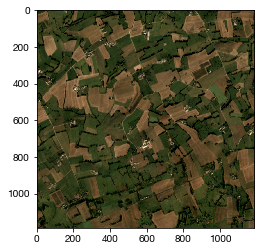

In [17]:
planet_img = imageio.imread('../data/planet/france/1250px/00028_2019_10.tif')
plt.imshow(planet_img)
plt.show()

## Recreated boxes in EPSG 3857

In [2]:
bbox_df = pd.read_csv('../data/planet/france/bbox_1250px_epsg3857.csv')

In [6]:
geometries = []
for i, row in bbox_df.iterrows():
    geom = box(row['min_x'], row['min_y'], row['max_x'], row['max_y'])
    geometries.append(geom)

In [9]:
bbox_df['geometry'] = geometries

In [17]:
gdf = gpd.GeoDataFrame(bbox_df, crs='epsg:3857')
# gdf = gdf.set_crs(3857)

In [19]:
gdf.to_crs('epsg:4326')

RuntimeError: b'no arguments in initialization list'

# Save Han and Burak's data as 256x256 px

In [4]:
base_path = '../data/planet/france/'
folders = ['april', 'january', 'october', 'labels']
size = 256

for i, folder in enumerate(folders):
    new_folder = folder + '_{}x{}'.format(size, size)
    if not os.path.exists(os.path.join(base_path, new_folder)):
        os.makedirs(os.path.join(base_path, new_folder))
        
    images = os.listdir(os.path.join(base_path, folder))
    
    for image in images:
        img = imageio.imread(os.path.join(base_path, folder, image))
        
        img = img[:size, :size]
        imageio.imwrite(os.path.join(base_path, new_folder, image), img)